--- Generating Graph Series ---
Sizes: [40, 60, 80, 100]
Connectivity: 0.2, Busy Node Interval: 5

Creating graph size: 40 (seed=82)...
  Graph created: 40 nodes, 150 edges.

Creating graph size: 60 (seed=102)...
  Graph created: 60 nodes, 339 edges.

Creating graph size: 80 (seed=122)...
  Graph created: 80 nodes, 640 edges.

Creating graph size: 100 (seed=142)...
  Graph created: 100 nodes, 994 edges.

--- Graph Generation Complete ---

--- Starting Hierarchical QL Benchmarking Across Sizes ---

=============== Processing Graph Size: 40 ===============
Initializing Hierarchical Q-Learning agent (k=8) for size 40...
Partitioned graph into 8 regions. Found 40 border nodes.

--- Starting Hierarchical QL Training (Size: 40, Regions: 8, Episodes: 25000) ---
  Ep 2500/25000 | Avg R(100): 80.36 | Avg S(100): 4.9 | Eps: 0.286
  Ep 5000/25000 | Avg R(100): 83.25 | Avg S(100): 4.3 | Eps: 0.082
  Ep 7500/25000 | Avg R(100): 79.34 | Avg S(100): 6.9 | Eps: 0.050
  Ep 10000/25000 | Avg R(100): 83.

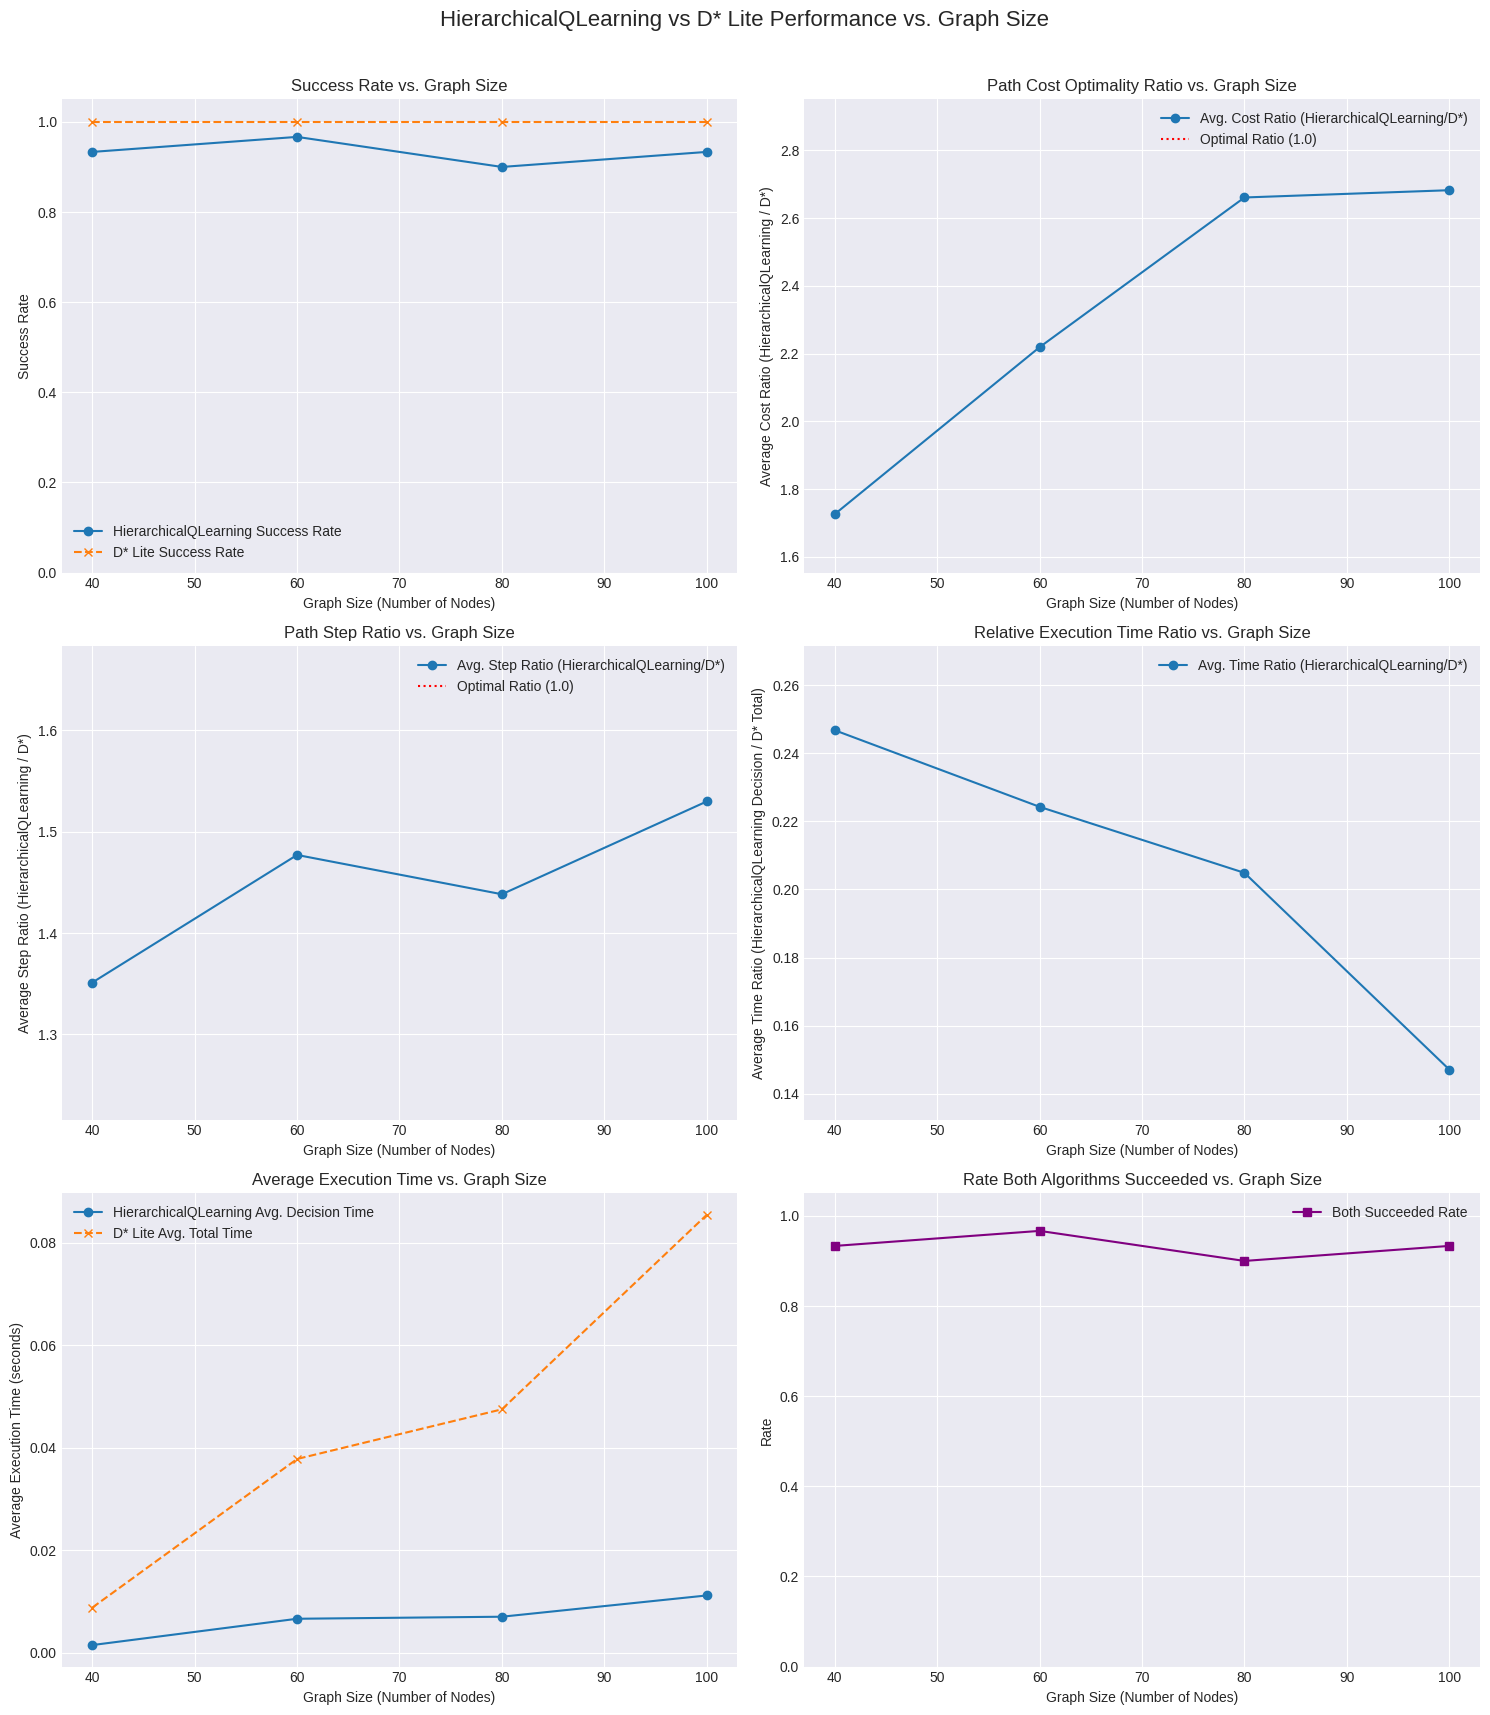


--- Experiment Finished ---


In [2]:
# --- Imports ---
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time
import heapq
from collections import defaultdict, deque
import copy
import json # For potentially saving results

# --- Graph Creation & Utilities (Keep as before) ---
# ... (create_dynamic_graph, update_edge_weights, reset_graph_weights) ...
# --- Modified Graph Creation with Scalable Index Pattern ---
def create_dynamic_graph(num_nodes=20, seed=42, connectivity=0.3,
                         busy_node_pattern_interval=5):
    """
    Creates a deterministic random graph with time-varying edge weights,
    assigns node positions, and selects busy nodes based on a consistent
    index interval pattern to ensure scalable distribution.
    """
    if num_nodes <= 0:
        print("Warning: num_nodes must be positive. Returning empty graph.")
        return nx.Graph()

    # Set seeds for reproducibility FOR THIS SPECIFIC GRAPH SIZE
    random.seed(seed)
    np.random.seed(seed)

    # Create a random graph (undirected)
    G = nx.erdos_renyi_graph(n=num_nodes, p=connectivity, seed=seed)

    # --- Ensure Connectivity ---
    max_attempts = num_nodes * 2
    attempts = 0
    # Only try to connect if there's more than one node
    if G.number_of_nodes() > 1:
        while not nx.is_connected(G) and attempts < max_attempts :
            components = list(nx.connected_components(G))
            if len(components) > 1:
                # Connect a random node from a smaller component to the largest one
                largest_component = max(components, key=len)
                other_components = [c for c in components if c != largest_component]
                # Choose a random component that is not the largest
                if not other_components: # Should not happen if len(components)>1, but safety check
                    break
                comp_to_connect = random.choice(other_components)

                u = random.choice(list(largest_component))
                v = random.choice(list(comp_to_connect))
                G.add_edge(u, v)
            # elif G.number_of_edges() == 0: # Handle case of all isolated nodes
            #      node_list = list(G.nodes())
            #      u = random.choice(node_list)
            #      v = random.choice([n for n in node_list if n != u])
            #      if u != v: G.add_edge(u, v)
            #      else: break # Only one node case covered earlier
            else: # Graph has edges but somehow len(components) <= 1 (should be connected)
                 break
            attempts += 1

        if attempts >= max_attempts and not nx.is_connected(G):
             print(f"Warning: Could not ensure graph connectivity for size {num_nodes} after {max_attempts} attempts.")

    # --- Define busy nodes using the scalable index pattern ---
    busy_nodes = []
    if num_nodes > 0 and busy_node_pattern_interval > 0:
        # Select nodes where index modulo interval is 0
        busy_nodes = [i for i in range(num_nodes) if i % busy_node_pattern_interval == 0]
    elif num_nodes > 0:
        print(f"Warning: Invalid busy_node_pattern_interval ({busy_node_pattern_interval}). No busy nodes selected.")

    # --- Assign initial edge weights and dynamic parameters ---
    for u, v in G.edges():
        is_busy_edge = (u in busy_nodes) or (v in busy_nodes)
        # Consistent weight distribution logic
        base_weight = random.uniform(7.0, 10.0) if is_busy_edge else random.uniform(1.0, 4.0)

        G[u][v]['weight'] = base_weight
        G[u][v]['base_weight'] = base_weight
        G[u][v]['variation'] = random.uniform(0.5, 2.5) # Consistent dynamic range
        G[u][v]['period'] = random.uniform(0.05, 0.3)   # Consistent dynamic speed

    # --- Assign node positions ---
    try:
        if G.number_of_nodes() > 50: # Use a potentially faster/better layout for large graphs
            G.pos = nx.kamada_kawai_layout(G)
        elif G.number_of_nodes() > 0:
            G.pos = nx.spring_layout(G, seed=seed) # Spring layout for smaller graphs
        else:
            G.pos = {} # Empty dict for empty graph
    except Exception as e: # Catch any layout error
         print(f"Warning: Layout algorithm failed for size {num_nodes} (seed={seed}, error={e}). Using random layout.")
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    # Ensure pos attribute exists
    if not hasattr(G, 'pos'):
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    return G

# --- Graph Utilities ---
def update_edge_weights(G, time_step):
    """Updates edge weights based on time step."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base = G[u][v].get('base_weight', 5.0)
        variation = G[u][v].get('variation', 1.0)
        period = G[u][v].get('period', 0.2)
        try:
            factor = np.sin(time_step * period) * variation
            G[u][v]['weight'] = max(0.1, base + factor)
        except Exception: G[u][v]['weight'] = base
    return G

def reset_graph_weights(G):
    """Resets edge weights to base values."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        G[u][v]['weight'] = G[u][v].get('base_weight', random.uniform(1, 10))
    return G


# --- D* Lite Implementation (Keep as before) ---
# ... (class DStarLite, navigate_with_dstar) ...
class DStarLite:
    # --- D* Lite Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, start, goal):
        self.G = graph # Should be a NetworkX Graph (undirected assumed)
        self.start = start
        self.goal = goal
        self.current = start # Agent's current position

        self.U = [] # Priority queue (min-heap)
        self.g = defaultdict(lambda: float('inf'))
        self.rhs = defaultdict(lambda: float('inf'))
        self.km = 0 # Key modifier for heuristic updates

        self.rhs[goal] = 0
        try:
            initial_key = self.calculate_key(goal)
            if not isinstance(initial_key, tuple) or len(initial_key) != 2:
                raise TypeError(f"Initial key for goal {goal} is not a valid tuple: {initial_key}")
            heapq.heappush(self.U, (initial_key, goal))
        except TypeError as e:
             print(f"Error pushing initial goal node {goal} to heap: {e}")
             print(f"Goal key calculation resulted in: {self.calculate_key(goal)}")
             raise

    def calculate_key(self, node):
        """Calculate the key for a node in the priority queue"""
        g_val = self.g[node]
        rhs_val = self.rhs[node]
        min_g_rhs = min(g_val, rhs_val)

        h_cost = self.heuristic(self.start, node)
        if not isinstance(h_cost, (int, float)): h_cost = 0
        return (min_g_rhs + h_cost + self.km, min_g_rhs)

    def heuristic(self, a, b):
        """Heuristic function (Euclidean distance if positions exist)"""
        if a not in self.G or b not in self.G: return 0
        if not hasattr(self.G, 'pos') or not self.G.pos: return 0
        if a not in self.G.pos or b not in self.G.pos: return 0
        pos_a, pos_b = self.G.pos[a], self.G.pos[b]
        if (isinstance(pos_a, (list, tuple)) and len(pos_a) >= 2 and
            isinstance(pos_b, (list, tuple)) and len(pos_b) >= 2 and
            all(isinstance(coord, (int, float)) for coord in pos_a[:2] + pos_b[:2])):
             try: return math.sqrt((pos_a[0] - pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)
             except (TypeError, ValueError): return 0
        return 0

    def update_vertex(self, u):
        """Update the RHS value and priority queue entry for a vertex"""
        if u != self.goal:
            min_rhs = float('inf')
            for v in self.G.neighbors(u):
                 cost = self.get_edge_cost(u, v)
                 if cost != float('inf') and self.g[v] != float('inf'):
                     min_rhs = min(min_rhs, cost + self.g[v])
            self.rhs[u] = min_rhs

        # Efficiently remove if exists
        # Check if u is in the queue (more robustly)
        u_in_queue_index = -1
        for i, (_, node) in enumerate(self.U):
            if node == u:
                u_in_queue_index = i
                break

        if u_in_queue_index != -1:
            # Remove u without rebuilding the entire heap if possible
            # This is a common optimization, though direct removal is O(N)
            # For simplicity here, we rebuild, but know there are faster ways
            self.U = [(key, node) for key, node in self.U if node != u]
            heapq.heapify(self.U)


        if self.g[u] != self.rhs[u]:
            try:
                 key_u = self.calculate_key(u)
                 if not isinstance(key_u, tuple) or len(key_u) != 2: raise TypeError(f"Invalid key: {key_u}")
                 heapq.heappush(self.U, (key_u, u))
            except TypeError as e:
                 print(f"Error pushing node {u} during update: {e}, Key: {self.calculate_key(u)}")

    def get_edge_cost(self, u, v):
         """Safely get edge cost."""
         if self.G.has_edge(u, v):
             weight = self.G[u][v].get('weight', float('inf'))
             # Ensure weight is a valid number, default to infinity if not
             if isinstance(weight, (int, float)) and not math.isnan(weight) and not math.isinf(weight):
                 return weight
             else:
                 # print(f"Warning: Invalid edge weight ({weight}) for edge ({u},{v}). Treating as inf.")
                 return float('inf')
         return float('inf')


    def compute_shortest_path(self):
        """Compute shortest path values."""
        # Limit computation steps to prevent infinite loops in tricky cases
        max_compute_steps = self.G.number_of_nodes() * self.G.number_of_nodes() * 2 # Heuristic limit
        compute_steps = 0

        # --- Main D* Lite Loop ---
        # Continue while the queue is not empty AND
        # (the priority of the top element is less than the key of the start node OR
        # the start node is inconsistent (rhs != g))
        while self.U and (not self.U or self.U[0][0] < self.calculate_key(self.start) or self.rhs[self.start] != self.g[self.start]):

            compute_steps += 1
            if compute_steps > max_compute_steps:
                 print(f"Warning: Exceeded D* compute step limit ({max_compute_steps}) for start={self.start}, goal={self.goal}. Pathfinding may fail.")
                 # Optionally, you could clear the queue or raise an error here
                 # For now, just break the loop to prevent freezing
                 break

            try:
                # Pop the node with the lowest priority key
                k_old, u = heapq.heappop(self.U)
            except IndexError:
                # Queue became empty unexpectedly
                # print(f"Warning: D* Queue empty during compute_shortest_path (start={self.start}, goal={self.goal}).")
                break # Exit loop

            # Calculate the current key for the popped node
            k_new = self.calculate_key(u)

            # --- Case 1: Key has increased (information changed making path through u look worse) ---
            if k_old < k_new:
                # Re-insert the node into the priority queue with its updated (higher) key
                try:
                    heapq.heappush(self.U, (k_new, u))
                except TypeError as e:
                    print(f"Error pushing node {u} (key increased) back to heap: {e}, Key: {k_new}")

            # --- Case 2: Node is "overconsistent" (g > rhs) ---
            # This means we found a potentially better path to u.
            elif self.g[u] > self.rhs[u]:
                # Update g(u) to the better value rhs(u)
                self.g[u] = self.rhs[u]
                # Propagate this change to the neighbors of u, as they might now have a better path *through* u.
                # Update_vertex for each neighbor will recalculate their rhs and update their queue status if needed.
                for s in self.G.neighbors(u):
                    self.update_vertex(s)

            # --- Case 3: Node is "underconsistent" (g < rhs, implicitly g != rhs checked by outer loop) ---
            # This means the previous path to u (which determined g(u)) is no longer valid or optimal.
            # We need to set g(u) to infinity and check u and its neighbors.
            else:
                # Store the old g-value (not strictly necessary for basic D*, but sometimes useful)
                g_old = self.g[u]
                # Set g(u) to infinity, indicating no known finite path from start to u currently.
                self.g[u] = float('inf')
                # We need to update u itself and its neighbors, as their paths might have relied on the old g(u).
                # Updating u ensures its rhs is recalculated based on neighbors potentially having finite g-values again.
                # Updating neighbors ensures their rhs values (which might have used the old g(u)) are recalculated.
                affected_nodes = list(self.G.neighbors(u)) + [u] # Include u itself
                for s in affected_nodes:
                    self.update_vertex(s)

            # Safety check for excessive queue size
            if len(self.U) > self.G.number_of_nodes() * 10: # Heuristic check
                 print(f"Warning: D* queue size potentially excessive ({len(self.U)} nodes). Check for cycles or large cost fluctuations.")
                 # Optionally break or clear queue here if it becomes a performance issue


    def get_next_node(self):
        """Get the best next node to move to from the current position."""
        if self.current == self.goal:
            return None # Already at the goal

        min_cost_plus_g = float('inf')
        next_node = None

        # Iterate through all neighbors of the current node
        neighbors = list(self.G.neighbors(self.current)) # Get neighbors once
        if not neighbors: return None # No neighbors to move to

        for neighbor in neighbors:
            cost = self.get_edge_cost(self.current, neighbor)
            g_neighbor = self.g[neighbor]

            # Skip if the edge is impassable or the neighbor is currently unreachable from start
            if cost == float('inf') or g_neighbor == float('inf'):
                continue

            current_cost_plus_g = cost + g_neighbor

            # --- Decision Logic ---
            # 1. If this neighbor offers a strictly better total cost (cost to move + estimated remaining cost from neighbor)
            if current_cost_plus_g < min_cost_plus_g:
                min_cost_plus_g = current_cost_plus_g
                next_node = neighbor
            # 2. Tie-breaking: If costs are equal, use heuristic to goal as a tie-breaker
            elif current_cost_plus_g == min_cost_plus_g and next_node is not None:
                 # Only calculate heuristics if needed for tie-breaking
                 h_neighbor = self.heuristic(neighbor, self.goal)
                 h_next_node = self.heuristic(next_node, self.goal)

                 # Prefer neighbor with lower heuristic cost to goal
                 if h_neighbor < h_next_node:
                      next_node = neighbor
                 # Final tie-breaker: If heuristics are also equal, prefer lower node index (arbitrary but deterministic)
                 elif h_neighbor == h_next_node and neighbor < next_node:
                      next_node = neighbor


        # After checking all neighbors, return the chosen best neighbor
        # If no valid neighbor was found (e.g., all disconnected or infinite cost), next_node remains None
        return next_node


    def move_to(self, node):
        """Update the agent's current position and the 'start' reference for planning."""
        if node is not None and node != self.current:
            self.current = node
            # Crucial: D* plans from the current position, so update 'start'
            self.start = node
            # OPTIONAL: Update km (key modifier) - Typically done here in full D* Lite
            # self.km += self.heuristic(self.last_start_pos_before_move, self.start) # Example update
            # self.last_start_pos_before_move = self.start # Need to track previous position

    def notify_edge_changes(self, changed_edges_info):
        """
        Notify D* about edge changes and trigger replanning.
        'changed_edges_info' can be a list of tuples (u, v, new_cost) or just [(u, v)]
        if the graph edge data itself was updated externally.
        """
        # In this implementation, we assume the graph G passed to __init__
        # is updated externally by update_edge_weights.
        # So, we don't need to explicitly pass new costs here.
        # We just need to know *which nodes* might be affected.

        # --- More Efficient Approach (if only some edges change) ---
        # nodes_to_update = set()
        # for u, v in changed_edges_info: # Assuming changed_edges_info is [(u,v), ...]
        #     # Update the vertices connected by the changed edges
        #     self.update_vertex(u)
        #     self.update_vertex(v)
        #     # Add neighbors too? Sometimes needed depending on specific D* variant details
        #     # for n in self.G.neighbors(u): nodes_to_update.add(n)
        #     # for n in self.G.neighbors(v): nodes_to_update.add(n)

        # --- Current Simple Approach (Assume all edges *might* change) ---
        # Since update_edge_weights modifies all edges, we consider all nodes potentially affected.
        # Recomputing for all nodes connected by edges is safer if update logic is complex.
        nodes_potentially_affected = set()
        for u, v in self.G.edges():
             nodes_potentially_affected.add(u)
             nodes_potentially_affected.add(v)


        # Update the vertices associated with potentially changed edges.
        # This will recalculate their rhs values based on current neighbors' g-values
        # and the *new* edge costs (obtained via self.get_edge_cost).
        # If a node becomes inconsistent (g != rhs), update_vertex adds/updates it in the queue.
        for node in nodes_potentially_affected:
            self.update_vertex(node)

        # After potentially adding inconsistent nodes to the queue, run compute_shortest_path
        # to propagate the changes and ensure the plan from the current start is optimal again.
        self.compute_shortest_path()

# --- D* Lite Navigation Function ---
# <<< Keep navigate_with_dstar function from the previous answer here >>>
def navigate_with_dstar(graph_instance, start_node, goal_node, max_steps=None):
    """Navigate using D* Lite, handling dynamic weights during navigation."""
    print(f"\n--- D* Lite Navigation: {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_nav = graph_instance # Use the graph directly
    if start_node not in G_nav or goal_node not in G_nav:
        print(f"Error: Start ({start_node}) or Goal ({goal_node}) node not in graph nodes {list(G_nav.nodes())}.")
        return [], float('inf'), 0, 0.0

    # Reset weights to base values before starting navigation
    reset_graph_weights(G_nav)

    try:
        # Initialize D* Lite planner
        planner = DStarLite(G_nav, start_node, goal_node)
    except Exception as e:
        print(f"Error initializing D* Lite planner: {e}")
        # Potentially log the full traceback here
        import traceback
        traceback.print_exc()
        return [], float('inf'), 0, 0.0

    current_node = start_node
    current_time_step = 0 # Use a more descriptive name
    total_cost = 0.0
    path = [current_node]

    # Set default max_steps if not provided
    if max_steps is None:
        max_steps = G_nav.number_of_nodes() * 2 # Default limit based on graph size

    start_time_exec = time.perf_counter()

    # Initial plan computation
    try:
        planner.compute_shortest_path()
    except Exception as e:
        print(f"Error during initial D* compute_shortest_path: {e}")
        end_time_exec = time.perf_counter()
        return [], float('inf'), 0, end_time_exec - start_time_exec

    # Check if a path exists initially (g[start] should be finite if goal is reachable)
    if planner.g[start_node] == float('inf'):
         print(f"D* Lite: Initial path planning failed (g[{start_node}]=inf). Goal might be unreachable.")
         end_time_exec = time.perf_counter()
         return [], float('inf'), 0, end_time_exec - start_time_exec

    # --- Navigation Loop ---
    while current_node != goal_node and current_time_step < max_steps:
        # 1. Update Environment: Simulate edge weight changes
        update_edge_weights(G_nav, current_time_step)

        # 2. Notify Planner & Replan: Inform D* about potential changes and let it replan
        #    We assume all edges *might* have changed due to the simple update_edge_weights.
        changed_edges_list = list(G_nav.edges()) # Get current edges
        try:
            # Pass the list of edges; planner will use get_edge_cost to see new weights
            planner.notify_edge_changes(changed_edges_list)
        except Exception as e:
            print(f"Error during D* notify_edge_changes/recompute at t={current_time_step}: {e}")
            # Pathfinding failed due to replanning error
            total_cost = float('inf')
            break # Exit the loop

        # 3. Get Next Action: Ask the planner for the best next node based on the current plan
        next_node = planner.get_next_node()

        # 4. Check for Failure or Goal:
        if next_node is None:
            if current_node == goal_node:
                 # Should have been caught by the loop condition, but safety check
                 break
            else:
                 # Planner couldn't find a next step from the current node
                 print(f"D* Lite: No path found from node {current_node} at time step t={current_time_step}. Pathfinding failed.")
                 total_cost = float('inf')
                 # Keep the partial path found so far
                 break # Exit the loop

        # 5. Execute Action: Move to the chosen next node
        #    Get the cost of the edge *at this time step*
        edge_cost = planner.get_edge_cost(current_node, next_node)

        # Sanity check the edge cost
        if edge_cost == float('inf'):
             print(f"D* Error: Planner chose an edge ({current_node},{next_node}) with infinite cost at t={current_time_step}! This shouldn't happen with correct logic.")
             total_cost = float('inf')
             # Pathfinding failed due to inconsistent state
             break # Exit the loop

        # Update total cost
        total_cost += edge_cost

        # Move the planner's internal state
        planner.move_to(next_node)

        # Update our tracking variables
        current_node = next_node
        path.append(current_node)
        current_time_step += 1

    # --- End of Navigation ---
    end_time_exec = time.perf_counter()
    elapsed_time = end_time_exec - start_time_exec

    # Determine success based on final state
    success = (current_node == goal_node and total_cost != float('inf'))

    # Print results
    if success:
        print(f"D* Lite: Reached goal.")
        print(f"  Path: {path}")
        print(f"  Cost: {total_cost:.2f}, Steps: {current_time_step}, Time: {elapsed_time:.4f}s")
    elif current_time_step >= max_steps:
        print(f"D* Lite: Failed (Max steps reached at {max_steps}).")
        print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")
    else:
        # Failed for other reasons (e.g., no path found mid-way)
        print(f"D* Lite: Failed (Path terminated).")
        if path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")


    # Return results
    # If successful, return the full path and its cost.
    # If failed, return the partial path found and infinite cost (or the cost accumulated so far if needed).
    # Let's return empty list and inf cost on failure for consistency with other parts.
    final_path = path if success else []
    final_cost = total_cost if success else float('inf')

    return final_path, final_cost, current_time_step, elapsed_time



# --- Base Q-Learning Agent (Keep as before) ---
class QLearningPathFinder:
    # --- Q-Learning Code (Exactly as in the previous corrected version) ---
    # Add a heuristic method reference
    def __init__(self, graph, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05, graph_positions=None):
        self.G_template = graph # Store the template graph structure/params
        self.nodes = list(graph.nodes()) if graph else []
        self.num_nodes = len(self.nodes)
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_exploration_rate
        self.q_table = defaultdict(lambda: defaultdict(float)) # Q(s,a)
        self.experience = deque(maxlen=10000) # Experience replay buffer D = [(s,a,r,s')]
        self.positions = graph_positions # Store positions if provided


    def get_state(self, current_node, goal_node):
        """Defines the state representation."""
        # State includes current location and the ultimate goal
        return (current_node, goal_node)

    def choose_action(self, state, available_actions, is_training=True):
        """Chooses an action using epsilon-greedy strategy."""
        if not available_actions:
            return None # No possible moves

        # Exploration: Choose a random action
        if is_training and random.random() < self.epsilon:
            return random.choice(available_actions)
        # Exploitation: Choose the best known action
        else:
            q_values = self.q_table[state]
            best_q_value = -float('inf')
            best_actions = []

            # Find all actions with the maximum Q-value
            for action_node in available_actions:
                q_val = q_values[action_node] # Q(state, action_node)
                if q_val > best_q_value:
                    best_q_value = q_val
                    best_actions = [action_node]
                elif q_val == best_q_value:
                    best_actions.append(action_node)

            # If multiple best actions, choose randomly among them
            if best_actions:
                return random.choice(best_actions)
            else:
                # If no Q-values are known (all are default 0 or negative), or no actions found, pick randomly
                return random.choice(available_actions) if available_actions else None


    def heuristic(self, node1, node2):
        """Heuristic function (e.g., Euclidean distance)."""
        if self.positions is None: return 0 # No position info
        if node1 not in self.positions or node2 not in self.positions: return 0

        pos1, pos2 = self.positions[node1], self.positions[node2]
        if (isinstance(pos1, (list, tuple)) and len(pos1) >= 2 and
            isinstance(pos2, (list, tuple)) and len(pos2) >= 2 and
            all(isinstance(c, (int, float)) for c in pos1[:2] + pos2[:2])):
            try:
                dist = math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
                return dist if not math.isnan(dist) else 0
            except (TypeError, ValueError):
                return 0 # Problem with position data
        return 0 # Invalid position format


    # Note: Reward calculation might be overridden or adapted by the Hierarchical manager
    def calculate_reward(self, G_instance, current_node, next_node, goal_node):
        """Calculates the reward for taking an action."""
        if not G_instance.has_edge(current_node, next_node):
            # print(f"Warning: Attempted move on non-existent edge ({current_node} -> {next_node})")
            return -100.0 # Heavy penalty for invalid moves

        # Get edge weight (cost)
        edge_weight = G_instance[current_node][next_node].get('weight', 100.0) # Default high cost
        if not isinstance(edge_weight, (int, float)) or math.isnan(edge_weight) or math.isinf(edge_weight):
            edge_weight = 100.0 # Use default high cost if weight is invalid

        # Base reward is negative cost (encourage low-cost paths)
        reward = -edge_weight

        # Bonus for reaching the goal
        if next_node == goal_node:
            reward += 100.0 # Significant bonus for reaching the destination

        # (Hierarchical version might add rewards for reaching border nodes here)

        return reward


    def update_q_value(self, state, action, reward, next_state, available_next_actions):
        """Updates the Q-value using the Bellman equation."""
        # Q(s, a) = Q(s, a) + alpha * [r + gamma * max_a'(Q(s', a')) - Q(s, a)]

        # Find the maximum Q-value for the next state (max_a' Q(s', a'))
        max_next_q = 0.0
        if available_next_actions:
            next_q_values = self.q_table[next_state] # Q-values for actions from next_state
            # Find the max Q-value among available actions from the next state
            # If no actions available from next state, max_next_q remains 0
            max_next_q = max((next_q_values[na] for na in available_next_actions), default=0.0)

        # Get the current Q-value
        current_q = self.q_table[state][action]

        # Calculate the new Q-value
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)

        # Update the Q-table
        self.q_table[state][action] = new_q


    def experience_replay(self, batch_size=32):
        """Updates Q-values using a batch of stored experiences."""
        if len(self.experience) < batch_size:
            return # Not enough experience yet

        # Sample a random mini-batch from the experience buffer
        mini_batch = random.sample(self.experience, batch_size)

        # Update Q-values for each experience in the mini-batch
        for state, action, reward, next_state, available_next_actions in mini_batch:
            # Note: In hierarchical setting, ensure the correct agent's Q-table is used
            # This basic replay assumes a single agent. The Hierarchical manager will handle routing.
            self.update_q_value(state, action, reward, next_state, available_next_actions)

    # The 'train' method will be part of the Hierarchical Manager now


# --- NEW: Graph Partitioning ---
def partition_graph_bfs(G, k):
    """
    Partitions the graph G into k regions using a simple BFS-based approach.

    Args:
        G: networkx Graph.
        k: Number of partitions (regions).

    Returns:
        A tuple containing:
        - node_to_region (dict): Mapping node ID to region ID (0 to k-1).
        - region_to_nodes (dict): Mapping region ID to a set of nodes in that region.
        - border_nodes (set): Set of all nodes that have neighbors in different regions.
    """
    if not G or G.number_of_nodes() == 0:
        return {}, {}, set()
    if k <= 0:
        k = 1 # Default to one partition if k is invalid
    if k > G.number_of_nodes():
        k = G.number_of_nodes() # Cannot have more regions than nodes

    nodes = list(G.nodes())
    random.shuffle(nodes) # Shuffle for randomness in seed selection
    seeds = nodes[:k]

    node_to_region = {node: -1 for node in G.nodes()}
    region_to_nodes = defaultdict(set)
    queues = [deque([seed]) for seed in seeds]
    for i, seed in enumerate(seeds):
        node_to_region[seed] = i
        region_to_nodes[i].add(seed)

    active_queues = list(range(k))
    processed_nodes = set(seeds)

    # Simultaneous BFS from all seeds
    while any(queues[i] for i in active_queues):
        next_active_queues = []
        for region_id in active_queues:
            q = queues[region_id]
            if not q: continue

            # Process one level of BFS for this region
            level_size = len(q)
            for _ in range(level_size):
                if not q: break # Should not happen if check above passed, but safety
                u = q.popleft()

                for v in G.neighbors(u):
                    if v not in processed_nodes:
                        processed_nodes.add(v)
                        node_to_region[v] = region_id
                        region_to_nodes[region_id].add(v)
                        q.append(v)

            if q: # If queue still has nodes for next level
                next_active_queues.append(region_id)

        active_queues = next_active_queues

    # Assign any remaining disconnected nodes (shouldn't happen if graph connected)
    unassigned_nodes = [n for n, r in node_to_region.items() if r == -1]
    if unassigned_nodes:
        print(f"Warning: {len(unassigned_nodes)} nodes were not reached by BFS partitioning. Assigning randomly.")
        nodes_per_region = G.number_of_nodes() // k
        for i, node in enumerate(unassigned_nodes):
             assigned_region = i // nodes_per_region
             assigned_region = min(assigned_region, k - 1) # Ensure valid region index
             node_to_region[node] = assigned_region
             region_to_nodes[assigned_region].add(node)


    # Identify border nodes
    border_nodes = set()
    for u in G.nodes():
        region_u = node_to_region[u]
        for v in G.neighbors(u):
            if node_to_region[v] != region_u:
                border_nodes.add(u)
                border_nodes.add(v) # Neighbor in other region is also border
                break # Found one neighbor in another region, u is a border node

    print(f"Partitioned graph into {k} regions. Found {len(border_nodes)} border nodes.")
    # print(f"Region sizes: {[len(nodes) for nodes in region_to_nodes.values()]}")

    return node_to_region, region_to_nodes, border_nodes


# --- NEW: Hierarchical Q-Learning Manager ---
class HierarchicalQLearning:
    def __init__(self, graph, k_regions, learning_rate=0.1, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05,
                 border_reward_factor=0.1): # Factor for heuristic reward at borders
        self.G_template = graph
        self.k = k_regions
        self.nodes = list(graph.nodes()) if graph else []
        self.num_nodes = len(self.nodes)
        self.positions = getattr(self.G_template, 'pos', None)

        # Partition the graph
        self.node_to_region, self.region_to_nodes, self.border_nodes = partition_graph_bfs(self.G_template, self.k)

        # Create sub-agents (QLearningPathFinder instances)
        self.agents = []
        for i in range(self.k):
            # Create a subgraph view for context? Or just use global graph? Let's use global.
            # Each agent still needs the global graph structure for rewards/transitions.
            agent = QLearningPathFinder(
                graph=self.G_template, # Provide full graph template
                learning_rate=learning_rate,
                discount_factor=discount_factor,
                exploration_rate=exploration_rate, # Each agent has its own epsilon
                exploration_decay=exploration_decay,
                min_exploration_rate=min_exploration_rate,
                graph_positions=self.positions # Pass positions for heuristic
            )
            self.agents.append(agent)

        # Global experience replay buffer (stores region ID too)
        self.experience = deque(maxlen=20000) # Maybe larger buffer for hierarchical
        self.gamma = discount_factor # Store gamma for border reward calculation
        self.border_reward_factor = border_reward_factor

    def get_agent_for_node(self, node):
        """Returns the agent responsible for the region containing the node."""
        region_id = self.node_to_region.get(node, -1)
        if 0 <= region_id < self.k:
            return self.agents[region_id]
        else:
            # This should not happen with correct partitioning
            print(f"Warning: Node {node} has invalid region ID {region_id}. Defaulting to agent 0.")
            return self.agents[0] # Fallback

    def get_region_id(self, node):
         return self.node_to_region.get(node, -1)

    def calculate_hierarchical_reward(self, G_instance, current_node, next_node, goal_node):
        """Calculates reward, potentially adding border transition incentive."""
        if not G_instance.has_edge(current_node, next_node):
            return -100.0 # Heavy penalty

        edge_weight = G_instance[current_node][next_node].get('weight', 100.0)
        if not isinstance(edge_weight, (int, float)) or math.isnan(edge_weight) or math.isinf(edge_weight):
            edge_weight = 100.0

        reward = -edge_weight # Base penalty for cost

        # Bonus for reaching the global goal
        if next_node == goal_node:
            reward += 100.0
        else:
            # Check for border crossing
            current_region = self.get_region_id(current_node)
            next_region = self.get_region_id(next_node)
            if current_region != next_region and current_region != -1 and next_region != -1:
                 # Crossed a border, not yet at goal. Add heuristic incentive?
                 # Use heuristic from the *next* node to the *global* goal
                 h_cost = self.agents[0].heuristic(next_node, goal_node) # Use any agent's heuristic
                 # Add a small reward proportional to the negative heuristic (closer is better)
                 # Scaled by gamma and a factor to keep it smaller than goal reward
                 border_bonus = self.border_reward_factor * self.gamma * (-h_cost)
                 reward += border_bonus
                 # print(f"Border cross {current_node}(R{current_region})->{next_node}(R{next_region}). BaseR={-edge_weight:.1f}, BorderB={border_bonus:.1f}, H={h_cost:.1f}")


        return reward

    def train(self, num_episodes=10000, max_steps_per_episode=150, experience_replay_batch_size=64):
        print(f"\n--- Starting Hierarchical QL Training (Size: {self.num_nodes}, Regions: {self.k}, Episodes: {num_episodes}) ---")
        stats = {'episode_rewards': [], 'episode_steps': []}
        if self.num_nodes < 2 or self.k == 0:
            print("Warning: Insufficient nodes or regions. Skipping training.")
            return stats

        G_train = self.G_template.copy() # Work on a copy for training episodes
        if hasattr(self.G_template, 'pos'): G_train.pos = self.G_template.pos
        start_train_time = time.perf_counter()
        nodes = list(self.nodes)

        for ep in range(num_episodes):
            # Sample global start and goal
            start_node, goal_node = random.sample(nodes, 2)
            current_node = start_node
            total_episode_reward = 0.0
            time_step = 0 # Tracks steps within the episode for dynamic weights

            reset_graph_weights(G_train) # Reset weights for the new episode

            for step in range(max_steps_per_episode):
                update_edge_weights(G_train, time_step) # Update dynamic weights

                current_region_id = self.get_region_id(current_node)
                if current_region_id == -1: # Should not happen
                     print(f"Error: current_node {current_node} has no region.")
                     break
                current_agent = self.agents[current_region_id]

                state = current_agent.get_state(current_node, goal_node) # Global goal in state
                available_actions = list(G_train.neighbors(current_node))

                if not available_actions: break # Stuck

                # Current agent chooses action based on its Q-table and epsilon
                action_node = current_agent.choose_action(state, available_actions, is_training=True)
                if action_node is None: break # Should not happen if actions available

                # Calculate reward (potentially using hierarchical logic)
                reward = self.calculate_hierarchical_reward(G_train, current_node, action_node, goal_node)
                total_episode_reward += reward

                # Determine next state and available actions from there
                next_node = action_node
                next_state = current_agent.get_state(next_node, goal_node) # State uses global goal
                available_next_actions = list(G_train.neighbors(next_node))

                # Store experience in the GLOBAL buffer, including the region ID of the state
                self.experience.append((state, action_node, reward, next_state, available_next_actions, current_region_id))

                # Perform experience replay using the global buffer
                if len(self.experience) >= experience_replay_batch_size:
                    self.experience_replay(experience_replay_batch_size)

                # Move to the next node
                current_node = next_node
                time_step += 1

                if current_node == goal_node:
                    break # Reached goal

            # End of episode
            stats['episode_rewards'].append(total_episode_reward)
            stats['episode_steps'].append(step + 1)

            # Decay epsilon for ALL agents (or maybe selectively?)
            # Let's decay all for simplicity
            for agent in self.agents:
                agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

            if (ep + 1) % (num_episodes // 10 or 500) == 0:
                 if len(stats['episode_rewards']) >= 100:
                    avg_r = np.mean(stats['episode_rewards'][-100:])
                    avg_s = np.mean(stats['episode_steps'][-100:])
                    # Use epsilon from agent 0 for display purposes
                    eps_disp = self.agents[0].epsilon
                    print(f"  Ep {ep+1}/{num_episodes} | Avg R(100): {avg_r:.2f} | Avg S(100): {avg_s:.1f} | Eps: {eps_disp:.3f}")
                 else: print(f"  Ep {ep+1}/{num_episodes} | Eps: {self.agents[0].epsilon:.3f}")

        print(f"--- Hierarchical QL Training Finished in {time.perf_counter() - start_train_time:.2f}s ---")
        return stats

    def experience_replay(self, batch_size):
         """Samples from global buffer and updates the relevant agent's Q-table."""
         if len(self.experience) < batch_size: return
         mini_batch = random.sample(self.experience, batch_size)

         for state, action, reward, next_state, available_next_actions, region_id in mini_batch:
             if 0 <= region_id < self.k:
                 agent_to_update = self.agents[region_id]
                 # *** Crucial Simplification ***
                 # The standard Q-update uses max_a' Q(s', a').
                 # In a hierarchical setting, s' might be in a *different* region.
                 # For simplicity here, we calculate max_next_q based *only* on the Q-values
                 # known to the agent responsible for the *original state's region* (agent_to_update).
                 # The reward signal (especially border reward) must guide cross-region policy.
                 max_next_q = 0.0
                 if available_next_actions:
                      next_q_values = agent_to_update.q_table[next_state]
                      max_next_q = max((next_q_values[na] for na in available_next_actions), default=0.0)

                 current_q = agent_to_update.q_table[state][action]
                 new_q = current_q + agent_to_update.alpha * (reward + agent_to_update.gamma * max_next_q - current_q)
                 agent_to_update.q_table[state][action] = new_q


    # --- Execution Method for Hierarchical Agent ---
    def execute_policy(self, graph_instance, start_node, goal_node, max_steps=None):
        """Finds a path using the learned hierarchical Q-policy."""
        print(f"\n--- Hierarchical QL Policy Exec: {start_node} -> {goal_node} (Size: {self.num_nodes}, Regions: {self.k}) ---")
        G_exec = graph_instance # Use the provided graph instance
        if start_node not in G_exec or goal_node not in G_exec:
             print(f"Error: Start/Goal node not in graph."); return [], float('inf'), 0, 0.0

        reset_graph_weights(G_exec) # Reset weights before execution
        current_node = start_node
        time_step = 0
        total_cost = 0.0
        path = [current_node]

        if max_steps is None:
            max_steps = self.num_nodes * 3 # Increased factor maybe

        start_time = time.perf_counter()
        while current_node != goal_node and time_step < max_steps:
            update_edge_weights(G_exec, time_step) # Update environment

            # Identify the agent and state for the current node
            current_region_id = self.get_region_id(current_node)
            if current_region_id == -1:
                 print(f"HQL Exec Error: Node {current_node} has no region. Aborting."); path=[]; total_cost=float('inf'); break
            active_agent = self.agents[current_region_id]
            state = active_agent.get_state(current_node, goal_node)

            available_actions = list(G_exec.neighbors(current_node))
            if not available_actions:
                print(f"HQL Exec: Stuck at {current_node} (no neighbors) at t={time_step}."); path=[]; total_cost=float('inf'); break

            # Choose action greedily using the active agent's policy
            next_node = active_agent.choose_action(state, available_actions, is_training=False)

            if next_node is None:
                print(f"HQL Exec: Cannot choose action from {current_node} (agent {current_region_id}) at t={time_step}."); path=[]; total_cost=float('inf'); break

            # Validate move and calculate cost
            if not G_exec.has_edge(current_node, next_node):
                 print(f"HQL Error: Policy chose non-existent edge ({current_node},{next_node})."); path=[]; total_cost=float('inf'); break

            edge_cost = G_exec[current_node][next_node].get('weight', float('inf'))
            if edge_cost == float('inf') or not isinstance(edge_cost,(int,float)) or math.isnan(edge_cost):
                 print(f"HQL Error: Edge ({current_node},{next_node}) invalid cost: {edge_cost}."); path=[]; total_cost=float('inf'); break

            total_cost += edge_cost
            current_node = next_node
            path.append(current_node)
            time_step += 1

        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        success = (current_node == goal_node and total_cost != float('inf'))

        print(f"HQL Policy: {'Reached goal' if success else ('Max steps' if time_step >= max_steps else 'Failed')}.")
        if success: print(f"  Path: {path}, Cost: {total_cost:.2f}, Steps: {time_step}, Time: {elapsed_time:.4f}s")
        elif path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")

        return path if success else [], total_cost if success else float('inf'), time_step, elapsed_time


# --- Benchmarking Framework (Adapt to call HierarchicalQLearning) ---
# The existing benchmark_algorithms should work if we pass the hierarchical agent
# It expects an object with an 'execute_policy' method matching the signature.
# We just need to instantiate and train HierarchicalQLearning instead of QLearningPathFinder in the main loop.

def benchmark_algorithms(graph_template, ql_agent, # Can be flat or hierarchical
                        num_test_pairs=10, max_steps_per_run=None, dstar_agent_type="DStarLite"): # added agent type just in case
    """Compares D* Lite and a trained Q-Learning agent (flat or hierarchical)"""
    n_nodes = graph_template.number_of_nodes()
    agent_name = ql_agent.__class__.__name__ # Get the class name (QLearningPathFinder or HierarchicalQLearning)
    print(f"\n--- Running Benchmark ({agent_name} vs {dstar_agent_type}) (Size: {n_nodes}, Pairs: {num_test_pairs}) ---")
    nodes_list = list(graph_template.nodes())
    if n_nodes < 2: print("Need >= 2 nodes."); return None
    if max_steps_per_run is None: max_steps_per_run = n_nodes * 3

    # Generate unique test pairs (same as before)
    test_pairs = set()
    attempts = 0; max_attempts = num_test_pairs * 5
    while len(test_pairs) < num_test_pairs and attempts < max_attempts:
        # Ensure start and goal are valid nodes in the graph
        valid_nodes = list(graph_template.nodes())
        if len(valid_nodes) < 2: break # Cannot sample 2 nodes
        source, dest = random.sample(valid_nodes, 2)
        test_pairs.add((source, dest))
        attempts += 1
    test_pairs = list(test_pairs)
    if len(test_pairs) < num_test_pairs: print(f"Warning: Generated {len(test_pairs)} unique pairs (requested {num_test_pairs}).")
    if not test_pairs: print("No valid test pairs generated."); return {'detailed_results': [], 'summary': {}}


    results = []
    all_ql_times, all_dstar_times = [], []
    all_ql_costs, all_dstar_costs = [], []
    all_ql_steps, all_dstar_steps = [], []
    successful_ql, successful_dstar, both_successful = 0, 0, 0

    for i, (source, dest) in enumerate(test_pairs):
        print(f"\n===== Test Pair {i+1}/{len(test_pairs)}: {source} -> {dest} (Size: {n_nodes}) =====")
        # Create deep copies for independent runs
        try:
             # Ensure the graph copies have the position attribute if the template does
             G_dstar = copy.deepcopy(graph_template)
             G_ql = copy.deepcopy(graph_template)
             if hasattr(graph_template, 'pos'):
                  if not hasattr(G_dstar, 'pos'): G_dstar.pos = graph_template.pos
                  if not hasattr(G_ql, 'pos'): G_ql.pos = graph_template.pos
        except Exception as e:
             print(f"Error deepcopying graph: {e}")
             continue

        # --- D* Lite Run ---
        dstar_path, dstar_cost, dstar_steps, dstar_time = navigate_with_dstar(
            G_dstar, source, dest, max_steps=max_steps_per_run)
        dstar_success = bool(dstar_path and dstar_path[-1] == dest and dstar_cost != float('inf'))

        # --- Q-Learning Run (using the provided agent, flat or hierarchical) ---
        # The ql_agent is already trained and passed in
        ql_path, ql_cost, ql_steps, ql_time = ql_agent.execute_policy( # Call the unified method name
            G_ql, source, dest, max_steps=max_steps_per_run)
        ql_success = bool(ql_path and ql_path[-1] == dest and ql_cost != float('inf'))

        # Store results (same structure as before)
        result_pair = {
            'source': source, 'destination': dest, 'size': n_nodes,
            'dstar_path': dstar_path, 'dstar_cost': dstar_cost, 'dstar_steps': dstar_steps,
            'dstar_time': dstar_time, 'dstar_success': dstar_success,
            'ql_path': ql_path, 'ql_cost': ql_cost, 'ql_steps': ql_steps,
            'ql_decision_time': ql_time, 'ql_success': ql_success,
            'cost_ratio': float('nan'), 'time_ratio': float('nan'), 'step_ratio': float('nan')
        }

        # Update aggregates and calculate ratios (same logic as before)
        if dstar_success:
            successful_dstar += 1
            all_dstar_costs.append(dstar_cost)
            all_dstar_steps.append(dstar_steps)
            all_dstar_times.append(dstar_time)
        if ql_success:
            successful_ql += 1
            all_ql_costs.append(ql_cost)
            all_ql_steps.append(ql_steps)
            all_ql_times.append(ql_time) # This is decision time for QL

        if ql_success and dstar_success:
            both_successful += 1
            # Calculate ratios safely, avoiding division by zero or near-zero
            if abs(dstar_cost) > 1e-9: result_pair['cost_ratio'] = ql_cost / dstar_cost
            elif abs(ql_cost) < 1e-9: result_pair['cost_ratio'] = 1.0 # Costs are both near zero
            else: result_pair['cost_ratio'] = float('inf') # QL cost > 0, D* cost near zero

            if abs(dstar_time) > 1e-9: result_pair['time_ratio'] = ql_time / dstar_time
            elif abs(ql_time) < 1e-9: result_pair['time_ratio'] = 1.0
            else: result_pair['time_ratio'] = float('inf')

            if dstar_steps > 0: result_pair['step_ratio'] = ql_steps / dstar_steps
            elif ql_steps == 0: result_pair['step_ratio'] = 1.0 # Both took 0 steps
            else: result_pair['step_ratio'] = float('inf') # QL > 0 steps, D* 0 steps

        results.append(result_pair)

        # Print pair results (same format as before)
        print("-" * 20)
        print(f"D* Success: {dstar_success}, Cost: {'INF' if dstar_cost==float('inf') else f'{dstar_cost:.2f}'}, Time: {dstar_time:.4f}")
        print(f"{agent_name} Success: {ql_success}, Cost: {'INF' if ql_cost==float('inf') else f'{ql_cost:.2f}'}, Time: {ql_time:.4f}")
        if ql_success and dstar_success:
            print(f"Cost Ratio ({agent_name}/D*): {result_pair['cost_ratio']:.3f}")
            print(f"Step Ratio ({agent_name}/D*): {result_pair['step_ratio']:.3f}")
            print(f"Time Ratio ({agent_name} Decision / D* Total): {result_pair['time_ratio']:.3f}")


    # Calculate Summary (same structure, variable names reflect the QL agent type)
    summary = {}
    num_run = len(test_pairs)
    if num_run > 0:
         summary['num_test_pairs'] = num_run; summary['node_size'] = n_nodes
         summary['agent_type'] = agent_name # Store agent type
         if isinstance(ql_agent, HierarchicalQLearning):
              summary['num_regions'] = ql_agent.k # Store number of regions if hierarchical

         summary['ql_success_rate'] = successful_ql / num_run
         summary['dstar_success_rate'] = successful_dstar / num_run
         summary['both_success_rate'] = both_successful / num_run
         summary['avg_ql_cost'] = np.mean(all_ql_costs) if all_ql_costs else float('nan')
         summary['avg_dstar_cost'] = np.mean(all_dstar_costs) if all_dstar_costs else float('nan')
         summary['avg_ql_steps'] = np.mean(all_ql_steps) if all_ql_steps else float('nan')
         summary['avg_dstar_steps'] = np.mean(all_dstar_steps) if all_dstar_steps else float('nan')
         summary['avg_ql_decision_time'] = np.mean(all_ql_times) if all_ql_times else float('nan')
         summary['avg_dstar_total_time'] = np.mean(all_dstar_times) if all_dstar_times else float('nan')

         # Calculate ratios based on pairs where both succeeded
         valid_cost_ratios = [r['cost_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['cost_ratio'])]
         valid_time_ratios = [r['time_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['time_ratio'])]
         valid_step_ratios = [r['step_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['step_ratio'])]

         summary['avg_cost_ratio'] = np.mean(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['median_cost_ratio'] = np.median(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['avg_time_ratio'] = np.mean(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['median_time_ratio'] = np.median(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['avg_step_ratio'] = np.mean(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['median_step_ratio'] = np.median(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['num_both_successful'] = both_successful


    # Print summary (adapted labels)
    print(f"\n===== Benchmark Summary ({agent_name} vs {dstar_agent_type} | Size: {n_nodes}) =====")
    if summary:
        print(f"Tested Pairs: {summary['num_test_pairs']}")
        if 'num_regions' in summary: print(f"Regions (k): {summary['num_regions']}")
        print(f"Success Rate - {agent_name}: {summary['ql_success_rate']:.2%} | D*: {summary['dstar_success_rate']:.2%}")
        print(f"Both Succeeded Rate: {summary['both_success_rate']:.2%} ({summary.get('num_both_successful', 0)} pairs)")
        print("-" * 20 + f"\nAverages (on successful runs):")
        print(f"  Cost     - {agent_name}: {summary['avg_ql_cost']:.2f} | D*: {summary['avg_dstar_cost']:.2f}")
        print(f"  Steps    - {agent_name}: {summary['avg_ql_steps']:.1f} | D*: {summary['avg_dstar_steps']:.1f}")
        print(f"  Time     - {agent_name} Decision: {summary['avg_ql_decision_time']:.4f}s | D* Total: {summary['avg_dstar_total_time']:.4f}s")
        print("-" * 20 + f"\nRatios ({summary.get('num_both_successful', 0)} pairs where both succeeded):")
        print(f"  Avg Cost Ratio ({agent_name}/D*): {summary['avg_cost_ratio']:.3f}")
        print(f"  Avg Step Ratio ({agent_name}/D*): {summary['avg_step_ratio']:.3f}")
        print(f"  Avg Time Ratio ({agent_name} / D*): {summary['avg_time_ratio']:.3f}")
    else:
        print("No results generated.")

    return {'detailed_results': results, 'summary': summary}


# --- Plotting Function (Keep as before, maybe adapt labels slightly if needed) ---
def plot_benchmark_results(all_benchmark_summaries):
    """Generates plots comparing performance metrics across graph sizes."""
    if not all_benchmark_summaries:
        print("No benchmark summaries available to plot.")
        return

    # Ensure summaries have the expected structure
    valid_summaries = [s for s in all_benchmark_summaries if s and 'summary' in s and 'node_size' in s['summary']]
    if not valid_summaries:
        print("No valid summaries found for plotting.")
        return

    # Extract agent type from the first valid summary for plot labels
    agent_type = valid_summaries[0]['summary'].get('agent_type', 'Q-Learning')

    # Sort summaries by node size
    valid_summaries.sort(key=lambda s: s['summary']['node_size'])
    sizes = [s['summary']['node_size'] for s in valid_summaries]

    if not sizes:
        print("No valid node sizes found in benchmark summaries.")
        return

    # Extract metrics, handling potential missing data or NaN values
    ql_success = [s['summary'].get('ql_success_rate', np.nan) for s in valid_summaries]
    dstar_success = [s['summary'].get('dstar_success_rate', np.nan) for s in valid_summaries]
    avg_cost_ratio = [s['summary'].get('avg_cost_ratio', np.nan) for s in valid_summaries]
    avg_step_ratio = [s['summary'].get('avg_step_ratio', np.nan) for s in valid_summaries]
    avg_time_ratio = [s['summary'].get('avg_time_ratio', np.nan) for s in valid_summaries]
    avg_ql_time = [s['summary'].get('avg_ql_decision_time', np.nan) for s in valid_summaries]
    avg_dstar_time = [s['summary'].get('avg_dstar_total_time', np.nan) for s in valid_summaries]
    both_success = [s['summary'].get('both_success_rate', np.nan) for s in valid_summaries]


    # Filter out NaN values for plotting lines where appropriate
    def filter_nan(x, y):
        y_array = np.array(y, dtype=float) # Ensure y is float array for isnan
        valid_indices = ~np.isnan(y_array)
        if not np.any(valid_indices): # Check if any valid data exists
             return np.array([]), np.array([])
        return np.array(x)[valid_indices], y_array[valid_indices]


    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    fig, axs = plt.subplots(3, 2, figsize=(15, 18)) # Create a grid of plots
    fig.suptitle(f'{agent_type} vs D* Lite Performance vs. Graph Size', fontsize=16)

    # --- Plotting Code (identical to before, but uses agent_type in labels) ---

    # Plot 1: Success Rate
    ax = axs[0, 0]
    s_f, ql_s_f = filter_nan(sizes, ql_success)
    ax.plot(s_f, ql_s_f, marker='o', linestyle='-', label=f'{agent_type} Success Rate')
    s_f, ds_s_f = filter_nan(sizes, dstar_success)
    ax.plot(s_f, ds_s_f, marker='x', linestyle='--', label='D* Lite Success Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05) # Success rate is between 0 and 1

    # Plot 2: Average Cost Ratio (QL/D*)
    ax = axs[0, 1]
    s_f, acr_f = filter_nan(sizes, avg_cost_ratio)
    ax.plot(s_f, acr_f, marker='o', linestyle='-', label=f'Avg. Cost Ratio ({agent_type}/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)') # Line for optimality
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel(f'Average Cost Ratio ({agent_type} / D*)')
    ax.set_title('Path Cost Optimality Ratio vs. Graph Size')
    ax.legend()
    # Consider setting y-axis limits based on data range if ratios vary wildly
    if len(acr_f)>0 : ax.set_ylim(bottom=max(0, np.min(acr_f)*0.9), top = np.max(acr_f)*1.1)


    # Plot 3: Average Step Ratio (QL/D*)
    ax = axs[1, 0]
    s_f, asr_f = filter_nan(sizes, avg_step_ratio)
    ax.plot(s_f, asr_f, marker='o', linestyle='-', label=f'Avg. Step Ratio ({agent_type}/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel(f'Average Step Ratio ({agent_type} / D*)')
    ax.set_title('Path Step Ratio vs. Graph Size')
    ax.legend()
    if len(asr_f)>0 : ax.set_ylim(bottom=max(0, np.min(asr_f)*0.9), top = np.max(asr_f)*1.1)


    # Plot 4: Average Time Ratio (QL Decision / D* Total)
    ax = axs[1, 1]
    s_f, atr_f = filter_nan(sizes, avg_time_ratio)
    ax.plot(s_f, atr_f, marker='o', linestyle='-', label=f'Avg. Time Ratio ({agent_type}/D*)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel(f'Average Time Ratio ({agent_type} Decision / D* Total)')
    ax.set_title('Relative Execution Time Ratio vs. Graph Size')
    ax.legend()
    # ax.set_ylim(bottom=0) # Time ratio should be non-negative
    if len(atr_f)>0 : ax.set_ylim(bottom=max(0, np.min(atr_f)*0.9), top = np.max(atr_f)*1.1)


    # Plot 5: Average Execution Time (Absolute)
    ax = axs[2, 0]
    s_f, qlt_f = filter_nan(sizes, avg_ql_time)
    ax.plot(s_f, qlt_f, marker='o', linestyle='-', label=f'{agent_type} Avg. Decision Time')
    s_f, dst_f = filter_nan(sizes, avg_dstar_time)
    ax.plot(s_f, dst_f, marker='x', linestyle='--', label='D* Lite Avg. Total Time')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Execution Time (seconds)')
    ax.set_title('Average Execution Time vs. Graph Size')
    # Use log scale only if times vary significantly AND are all positive
    if len(qlt_f) > 0 and len(dst_f) > 0 and np.min(qlt_f) > 1e-9 and np.min(dst_f) > 1e-9:
         if np.max(qlt_f)/np.min(qlt_f) > 10 or np.max(dst_f)/np.min(dst_f) > 10:
              ax.set_yscale('log')
              ax.set_ylim(bottom=1e-5) # Ensure log scale starts above zero
    ax.legend()


    # Plot 6: Both Success Rate
    ax = axs[2, 1]
    s_f, bs_f = filter_nan(sizes, both_success)
    ax.plot(s_f, bs_f, marker='s', linestyle='-', color='purple', label='Both Succeeded Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Rate')
    ax.set_title('Rate Both Algorithms Succeeded vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
    plt.show()



# --- Main Execution (Modified for Hierarchical QL) ---
if __name__ == "__main__":

    # --- Configuration ---
    NODE_SIZES = list(range(40, 101, 20)) # Example: Test 40, 60, 80, 100 nodes
    BASE_SEED = 42
    CONNECTIVITY = 0.20 # Maybe slightly sparser for larger graphs
    BUSY_NODE_INTERVAL = 5

    # Hierarchical Q-Learning Parameters
    NUM_REGIONS_FACTOR = 0.2 # Target k = num_nodes * factor (e.g., 20% -> 5 regions for 100 nodes)
    HQL_EPISODES_PER_SIZE = 25000 # May need more episodes for HQL? Or fewer per agent? Needs tuning.
    HQL_MAX_STEPS_FACTOR = 4      # Allow more steps potentially
    HQL_BATCH_SIZE = 64
    HQL_BORDER_REWARD_FACTOR = 0.05 # Tune this carefully! How much to incentivize border crossing.

    # Benchmarking Parameters
    NUM_TEST_PAIRS_PER_SIZE = 30  # Reduced for potentially slower HQL execution/training
    MAX_BENCHMARK_STEPS_FACTOR = 4

    # --- Graph Generation (Same as before) ---
    graphs = {}
    print("--- Generating Graph Series ---")
    print(f"Sizes: {NODE_SIZES}")
    print(f"Connectivity: {CONNECTIVITY}, Busy Node Interval: {BUSY_NODE_INTERVAL}")
    for n_nodes in NODE_SIZES:
        current_seed = BASE_SEED + n_nodes
        print(f"\nCreating graph size: {n_nodes} (seed={current_seed})...")
        try:
            G = create_dynamic_graph(
                num_nodes=n_nodes,
                seed=current_seed,
                connectivity=CONNECTIVITY,
                busy_node_pattern_interval=BUSY_NODE_INTERVAL
            )
            if G.number_of_nodes() != n_nodes:
                 print(f"  Warning: Graph creation resulted in {G.number_of_nodes()} nodes, expected {n_nodes}.")
            if G.number_of_nodes() >= 2 and not nx.is_connected(G):
                 # HQL might still work on disconnected graphs if start/goal in same component
                 print(f"  WARNING: Graph for size {n_nodes} is disconnected.")
            graphs[n_nodes] = G
            print(f"  Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
        except Exception as e:
            print(f"  ERROR creating graph for size {n_nodes}: {e}")
            graphs[n_nodes] = None
    print("\n--- Graph Generation Complete ---")


    # --- Benchmarking Loop (Using Hierarchical QL) ---
    all_benchmark_summaries = []
    print("\n--- Starting Hierarchical QL Benchmarking Across Sizes ---")

    for n_nodes in NODE_SIZES:
        print(f"\n{'='*15} Processing Graph Size: {n_nodes} {'='*15}")
        graph_template = graphs.get(n_nodes)

        if graph_template is None or graph_template.number_of_nodes() < 2:
            print(f"Skipping size {n_nodes} due to graph creation failure or insufficient nodes.")
            continue

        # Calculate number of regions for this size
        k = max(1, int(n_nodes * NUM_REGIONS_FACTOR)) # Ensure at least 1 region

        # 1. Instantiate and Train Hierarchical Q-Learning Agent FOR THIS SIZE
        print(f"Initializing Hierarchical Q-Learning agent (k={k}) for size {n_nodes}...")
        hql_agent = HierarchicalQLearning(
            graph=graph_template,
            k_regions=k,
            learning_rate=0.1,       # Tune these HRL parameters
            discount_factor=0.95,
            exploration_rate=1.0,
            exploration_decay=0.9995, # Slower decay might be needed?
            min_exploration_rate=0.05,
            border_reward_factor=HQL_BORDER_REWARD_FACTOR
        )

        # Train the agent
        current_num_episodes = HQL_EPISODES_PER_SIZE
        current_max_steps = n_nodes * HQL_MAX_STEPS_FACTOR
        try:
             training_stats = hql_agent.train(
                num_episodes=current_num_episodes,
                max_steps_per_episode=current_max_steps,
                experience_replay_batch_size=HQL_BATCH_SIZE
             )
             if not training_stats or not training_stats.get('episode_rewards'):
                  print(f"Warning: HQL training might have failed or produced no stats for size {n_nodes}.")
        except Exception as e:
             print(f"ERROR during HQL training for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()
             print("Skipping benchmarking for this size.")
             continue # Skip to next size if training fails

        # 2. Run Benchmark for this size using the trained HQL agent
        print(f"\nRunning benchmark for size {n_nodes} (k={k})...")
        try:
             # Pass the trained hierarchical agent to the benchmark function
             benchmark_results = benchmark_algorithms(
                graph_template=graph_template,
                ql_agent=hql_agent, # Pass the HQL agent here
                num_test_pairs=NUM_TEST_PAIRS_PER_SIZE,
                max_steps_per_run=(n_nodes * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_results and 'summary' in benchmark_results:
                 # Add size info to the summary before storing (already done in benchmark func)
                 all_benchmark_summaries.append(benchmark_results)
             else:
                 print(f"Warning: Benchmark for size {n_nodes} did not return valid results.")
        except Exception as e:
             print(f"ERROR during benchmarking for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()


    print("\n--- Benchmarking Across Sizes Complete ---")

    # --- Plotting Results ---
    print("\n--- Generating Performance Plots ---")
    plot_benchmark_results(all_benchmark_summaries)

    print("\n--- Experiment Finished ---")

#Partion based on graph changing weights